In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pprint
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")
import arviz as az
import scipy
import matplotlib.patches as patches
import statsmodels.stats.api as sms
from sklearn.metrics import r2_score
import scipy.stats.kde as kde

# Read meta data (RS maize)

In [6]:
df_meta = pd.read_csv('./metadata.txt', sep='\t', index_col=0)
df_meta = df_meta[['Group','Subject_ID','status']]
df_meta = df_meta[df_meta.Group=='himaize']
df_meta['Day'] = [0 if s=='before' else 21 for s in df_meta.status]
df_meta = df_meta.drop(['Group','status'], axis=1)
df_meta.columns = ['Subject','Day']
df_meta.head()

,Subject,Day
#SampleID,,
SRR6444429,U043,0
SRR6444301,U043,0
SRR6445037,U043,0
SRR6444018,U043,0
SRR6444126,U044,0


# Read SCFA

In [7]:
df_scfa = pd.read_csv('./metadata.txt', sep='\t', index_col=0)
df_scfa = df_scfa[['Acetate','Butyrate','Propionate']]
df_scfa = df_scfa.loc[df_meta.index].astype('float64')
df_scfa = df_scfa.loc[df_meta.index]
df_scfa.head()

,Acetate,Butyrate,Propionate
#SampleID,,,
SRR6444429,17.175159,7.759564,8.328110
SRR6444301,28.536974,7.211393,25.755624
SRR6445037,30.707725,7.657131,11.569308
SRR6444018,34.015677,4.409385,63.446699
SRR6444126,15.682373,3.993663,2.178766


In [8]:
df_scfa.corr()

,Acetate,Butyrate,Propionate
Acetate,1.000000,0.504723,0.391574
Butyrate,0.504723,1.000000,0.195253
Propionate,0.391574,0.195253,1.000000


# Read 16S data (relative abundance)

In [9]:
df_16S = pd.read_excel('16S_relative_abundance.xlsx', index_col=0)
df_16S = df_16S.loc[df_meta.index]
df_16S.head()

,Absiella-argi,Absiella-dolichum,Acetanaerobacterium,Acetoanaerobium,Acetobacterium,Acidaminococcus-intestini,Acidaminococcus-sp.-Marseille-P2828,Acinetobacter,Actinobacillus,Actinobacteria,...,human-gut-metagenome,iron-reducing-bacterium-enrichment-culture-clone-HN70,marine-group,marine-sediment-metagenome,metagenome,rumen-bacterium-YS2,soil-metagenome,swine-fecal-bacterium-SD-Pec5,vadinBE97,wallaby-gut-metagenome
#SampleID,,,,,,,,,,,,,,,,,,,,,
SRR6444429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002216,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
SRR6444301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
SRR6445037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002090,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
SRR6444018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002053,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
SRR6444126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.038660,0.0,0.0,0.0,0.003318,0.0,0.0,0.0,0.0,0.0


# Select the 40 most abundant taxa

In [10]:
topX = 40
df_16S_T = df_16S.T
df_16S_T['mean'] = df_16S_T.mean(axis=1)
df_16S_T = df_16S_T.sort_values(by=['mean'],axis=0,ascending=False)
df_16S_T = df_16S_T.drop('mean', axis=1)
df_16S_topX = df_16S_T.iloc[0:topX].T
df_16S_topX.head()

,Bacteroides,Faecalibacterium,Prevotella,Lachnospiraceae,Trichuris-trichiura-(human-whipworm),Ruminococcus-sp.-N15.MGS-57,Alistipes,gut-metagenome,Parabacteroides,Bacteroides-plebeius-DSM-17135,...,Coprococcus,[Eubacterium]-hallii-group,Pasteurellaceae,Odoribacter,Akkermansia,UCG-002,Dialister,[Eubacterium]-eligens-group,Blautia-faecis,Barnesiella
#SampleID,,,,,,,,,,,,,,,,,,,,,
SRR6444429,0.501445,0.124880,0.000000,0.019657,0.000000,0.027847,0.007420,0.001445,0.001542,0.000000,...,0.000000,0.000000,0.035749,0.000000,0.0,0.000000,0.0,0.015610,0.000000,0.000000
SRR6444301,0.540191,0.134415,0.000000,0.011015,0.000000,0.056416,0.019649,0.001786,0.000000,0.000000,...,0.000000,0.000000,0.036618,0.000000,0.0,0.000000,0.0,0.022030,0.000000,0.000000
SRR6445037,0.536087,0.144430,0.000000,0.006992,0.000000,0.043160,0.052403,0.004983,0.000000,0.000482,...,0.000000,0.000000,0.032069,0.000000,0.0,0.000000,0.0,0.030301,0.000000,0.000000
SRR6444018,0.401448,0.230649,0.000000,0.012964,0.000000,0.041754,0.024091,0.004267,0.000000,0.000000,...,0.000000,0.000000,0.030411,0.000000,0.0,0.000000,0.0,0.010317,0.000000,0.000000
SRR6444126,0.076721,0.094047,0.018984,0.020966,0.012994,0.000000,0.043176,0.071053,0.011289,0.000000,...,0.050825,0.015529,0.000000,0.004377,0.0,0.021427,0.0,0.000000,0.004009,0.007327


In [11]:
# sample with minimum absolute abundance coverage
(df_16S_topX.sum(axis=1)/df_16S.sum(axis=1)).min()

0.5251292202793357

# merge with metadata

In [12]:
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_meta = df_scfa_meta.groupby(['Subject','Day']).agg(np.nanmean).reset_index()
df_scfa_meta = df_scfa_meta.dropna()
df_scfa_meta = df_scfa_meta[df_scfa_meta.Subject.isin([s for s in df_scfa_meta.Subject if len(df_scfa_meta[df_scfa_meta.Subject==s])==2])].reset_index(drop=True)
df_scfa_meta.head()

,Subject,Day,Acetate,Butyrate,Propionate
0,U043,0,27.608884,6.759368,27.274935
1,U043,21,26.834273,4.975941,7.722552
2,U044,0,36.504464,10.376746,39.310800
3,U044,21,34.620354,9.027520,10.506632
4,U045,0,32.612388,9.401300,15.411272


In [13]:
df_16S_topX_meta = pd.merge(df_meta, df_16S_topX, left_index=True, right_index=True, how='inner')
df_16S_topX_meta = df_16S_topX_meta.groupby(['Subject','Day']).agg(np.nanmean).reset_index()
df_16S_topX_meta = pd.merge(df_16S_topX_meta, df_scfa_meta[['Subject','Day']], left_on=['Subject','Day'], right_on=['Subject','Day'], how='inner').reset_index(drop=True)
df_16S_topX_meta.head()

,Subject,Day,Bacteroides,Faecalibacterium,Prevotella,Lachnospiraceae,Trichuris-trichiura-(human-whipworm),Ruminococcus-sp.-N15.MGS-57,Alistipes,gut-metagenome,...,Coprococcus,[Eubacterium]-hallii-group,Pasteurellaceae,Odoribacter,Akkermansia,UCG-002,Dialister,[Eubacterium]-eligens-group,Blautia-faecis,Barnesiella
0,U043,0,0.494793,0.158593,0.000000,0.012657,0.000000,0.042294,0.025891,0.003121,...,0.000000,0.000000,0.033712,0.000000,0.000000,0.000000,0.0,0.019564,0.000000,0.000000
1,U043,21,0.463869,0.141472,0.004151,0.013976,0.002175,0.059544,0.035551,0.002604,...,0.000000,0.000000,0.039929,0.000000,0.000000,0.000000,0.0,0.040241,0.000000,0.000000
2,U044,0,0.059382,0.078831,0.127565,0.030048,0.007715,0.000139,0.040282,0.066812,...,0.032933,0.013173,0.000000,0.003425,0.000000,0.012549,0.0,0.000249,0.005065,0.006641
3,U044,21,0.046442,0.056133,0.133695,0.068241,0.009556,0.000321,0.043431,0.082519,...,0.029246,0.009839,0.000146,0.002709,0.000130,0.021305,0.0,0.000425,0.004975,0.004894
4,U045,0,0.082717,0.081320,0.119143,0.050266,0.115813,0.047440,0.013091,0.005671,...,0.014403,0.013677,0.000000,0.002063,0.000368,0.003332,0.0,0.001078,0.005425,0.004483


# Calculate derivative

In [14]:
df_scfa_deriv = deepcopy(df_scfa_meta)
for curr_mice in set(df_scfa_deriv.Subject):
    curr_df = df_scfa_meta[df_scfa_meta.Subject==curr_mice]
    for scfa in ['Acetate','Butyrate','Propionate']:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[scfa])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_scfa_deriv.loc[df_scfa_deriv.Subject==curr_mice, scfa] = ydata_d1
    
df_scfa_deriv = df_scfa_deriv[['Acetate','Butyrate','Propionate']]
df_scfa_deriv.head()

,Acetate,Butyrate,Propionate
0,-0.036886,-0.084925,-0.931066
1,-0.036886,-0.084925,-0.931066
2,-0.089720,-0.064249,-1.371627
3,-0.089720,-0.064249,-1.371627
4,-0.333907,-0.166556,-0.249274


# Normalize max value of 16S data to 1

In [15]:
# normalize bacteria data using 
df_16S_topX = df_16S_topX_meta.drop(['Subject','Day'], axis=1)
bacterial_taxa = list(df_16S_topX.columns)
df_16S_topX = df_16S_topX/df_16S_topX.max().max()
df_16S_topX.head()

,Bacteroides,Faecalibacterium,Prevotella,Lachnospiraceae,Trichuris-trichiura-(human-whipworm),Ruminococcus-sp.-N15.MGS-57,Alistipes,gut-metagenome,Parabacteroides,Bacteroides-plebeius-DSM-17135,...,Coprococcus,[Eubacterium]-hallii-group,Pasteurellaceae,Odoribacter,Akkermansia,UCG-002,Dialister,[Eubacterium]-eligens-group,Blautia-faecis,Barnesiella
0,0.667875,0.214070,0.000000,0.017085,0.000000,0.057089,0.034947,0.004212,0.000520,0.000163,...,0.000000,0.000000,0.045504,0.000000,0.000000,0.000000,0.0,0.026408,0.000000,0.000000
1,0.626133,0.190960,0.005604,0.018865,0.002935,0.080373,0.047987,0.003515,0.000387,0.000000,...,0.000000,0.000000,0.053897,0.000000,0.000000,0.000000,0.0,0.054318,0.000000,0.000000
2,0.080154,0.106407,0.172189,0.040559,0.010414,0.000187,0.054373,0.090184,0.020820,0.000000,...,0.044453,0.017781,0.000000,0.004623,0.000000,0.016939,0.0,0.000337,0.006837,0.008964
3,0.062688,0.075769,0.180462,0.092112,0.012899,0.000434,0.058623,0.111384,0.017706,0.000000,...,0.039476,0.013281,0.000197,0.003656,0.000176,0.028757,0.0,0.000574,0.006716,0.006606
4,0.111652,0.109767,0.160820,0.067850,0.156325,0.064035,0.017670,0.007655,0.010047,0.000000,...,0.019441,0.018462,0.000000,0.002784,0.000496,0.004497,0.0,0.001455,0.007323,0.006052


# Simple Correlation

In [16]:
lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    for t in bacterial_taxa:
        lines.append([scfa,
                     t,
                     pearsonr(df_scfa_deriv[scfa],df_16S_topX[t])[0],
                     spearmanr(df_scfa_deriv[scfa],df_16S_topX[t])[0]]
                    )
df_corr = pd.DataFrame(lines, columns=['SCFA','Variable','Pearson','Spearman'])
df_corr.head()

,SCFA,Variable,Pearson,Spearman
0,Acetate,Bacteroides,-0.101327,-0.163815
1,Acetate,Faecalibacterium,-0.048144,-0.147478
2,Acetate,Prevotella,-0.099170,0.007305
3,Acetate,Lachnospiraceae,-0.082816,-0.051711
4,Acetate,Trichuris-trichiura-(human-whipworm),0.259669,0.056560


In [17]:
df_corr.to_excel('correlation_top40_RS_maize.xlsx')

# Elastic net

In [18]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)
    l1_ratio = [1e-4, .1, .3, .5, .7, .9, .95, .99, 1]
    reg = ElasticNetCV(
        eps=1e-4,
        n_alphas=10000,
        cv=5,
        random_state=0,
        max_iter=100000,
        tol=1e-6,
        l1_ratio=l1_ratio
    ).fit(X, dydt)
    clf = ElasticNet(l1_ratio=reg.l1_ratio_, 
                     alpha=reg.alpha_, 
                     random_state=0,
                     max_iter=100000,
                     tol=1e-6,
                    ).fit(X,dydt)
    rows.append([scfa, reg.alpha_, reg.l1_ratio_, clf.score(X,dydt)]+ list(clf.coef_))
df_elasticnet = pd.DataFrame(rows, columns=['SCFA','BestAlpha','L1Ratio','R2']+list(df_16S_topX.columns)).set_index('SCFA')
#df_elasticnet = df_elasticnet.loc[:, (df_elasticnet != 0).any(axis=0)]
df_elasticnet.head()

,BestAlpha,L1Ratio,R2,Bacteroides,Faecalibacterium,Prevotella,Lachnospiraceae,Trichuris-trichiura-(human-whipworm),Ruminococcus-sp.-N15.MGS-57,Alistipes,...,Coprococcus,[Eubacterium]-hallii-group,Pasteurellaceae,Odoribacter,Akkermansia,UCG-002,Dialister,[Eubacterium]-eligens-group,Blautia-faecis,Barnesiella
SCFA,,,,,,,,,,,,,,,,,,,,,
Acetate,0.012706,0.1,0.165065,-0.320310,-0.142238,-0.661705,-0.037104,0.845460,0.065227,0.147546,...,-0.00000,0.0,-0.0,-0.0,0.317314,0.001547,0.000000,0.000000,0.0,-0.0
Butyrate,0.001810,0.1,0.505904,-0.078472,-0.537854,-0.240182,-0.014814,0.937263,-0.075071,0.295856,...,-0.14731,-0.0,0.0,0.0,0.437243,0.228624,0.008856,-0.025271,-0.0,-0.0
Propionate,0.014740,0.1,0.082261,-0.127390,0.125174,-0.866675,0.000000,0.361551,-0.259770,-0.021899,...,-0.00000,0.0,-0.0,-0.0,0.282486,-0.000000,0.001247,0.000000,0.0,-0.0


In [19]:
df_elasticnet = df_elasticnet.stack().reset_index()
df_elasticnet = df_elasticnet[~df_elasticnet.level_1.isin(['BestAlpha','L1Ratio','R2'])]
df_elasticnet.columns=['SCFA','Variable','Coefficient']
df_elasticnet = df_elasticnet.reset_index(drop=True)
df_elasticnet.to_excel('elasticnet_summary_top40_RS_maize.xlsx')

# Random forest regression

## parameter optimization

In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)

    # grid search
    rf = RandomForestRegressor()
    rf_random = GridSearchCV(
        estimator = rf, 
        param_grid = random_grid, 
        cv = 5, 
        verbose=2, 
        n_jobs = -1)

    # fit the random search model
    rf_random.fit(X, dydt)
    
    # write to table
    lines.append([scfa,
           rf_random.best_params_['n_estimators'],
           rf_random.best_params_['max_features'],
           rf_random.best_params_['max_depth'],
           rf_random.best_params_['min_samples_split'],
           rf_random.best_params_['min_samples_leaf'],
           rf_random.best_params_['bootstrap']
           ])

df_opt_paras = pd.DataFrame(lines, columns=['SCFA','n_estimators','max_features','max_depth','min_samples_split','min_samples_leaf','bootstrap'])
df_opt_paras.head()

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 20.5min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 23.4min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 24.6min finished


,SCFA,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap
0,Acetate,650,sqrt,30.0,2,4,True
1,Butyrate,200,sqrt,10.0,5,2,True
2,Propionate,1100,sqrt,NaN,5,4,True


In [30]:
df_opt_paras.to_excel('optimal_rf_hyperparameters_top40_RS_maize.xlsx')

## run RF using best parameters

In [31]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)
    regr = RandomForestRegressor(
        random_state=0,
        bootstrap=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'bootstrap'])[0],
        max_depth=None if str(list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0])=='nan' else list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0],
        max_features=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_features'])[0],
        min_samples_leaf=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_leaf'])[0],
        min_samples_split=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_split'])[0],
        n_estimators=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'n_estimators'])[0],
        n_jobs=-1
    )
    clf = regr.fit(X, dydt)
    rows.append([scfa, clf.score(X, dydt)]+ list(clf.feature_importances_))
df_rf = pd.DataFrame(rows, columns=['SCFA','R2']+list(df_16S_topX.columns))
df_rf.head()

,SCFA,R2,Bacteroides,Faecalibacterium,Prevotella,Lachnospiraceae,Trichuris-trichiura-(human-whipworm),Ruminococcus-sp.-N15.MGS-57,Alistipes,gut-metagenome,...,Coprococcus,[Eubacterium]-hallii-group,Pasteurellaceae,Odoribacter,Akkermansia,UCG-002,Dialister,[Eubacterium]-eligens-group,Blautia-faecis,Barnesiella
0,Acetate,0.657824,0.027732,0.031571,0.020950,0.019920,0.030112,0.020785,0.042649,0.033184,...,0.014687,0.023249,0.023437,0.037387,0.043089,0.021061,0.009511,0.016157,0.040203,0.011417
1,Butyrate,0.823217,0.035705,0.030756,0.017498,0.016895,0.108933,0.009194,0.017382,0.073580,...,0.015583,0.010333,0.012815,0.015983,0.024863,0.039466,0.010361,0.010363,0.020471,0.011379
2,Propionate,0.573247,0.015909,0.024949,0.033608,0.034219,0.009899,0.025575,0.013442,0.016913,...,0.017356,0.029825,0.023876,0.030383,0.029712,0.024486,0.051502,0.016581,0.020221,0.027136


In [32]:
df_rf = df_rf.set_index('SCFA').stack().reset_index()
df_rf = df_rf[~df_rf.level_1.isin(['R2'])]
df_rf.columns=['SCFA','Variable','Gini']
df_rf = df_rf.reset_index(drop=True)
df_rf.to_excel('rf_importance_top40_RS_maize.xlsx')

# Combine results

In [2]:
df_corr = pd.read_excel('correlation_top40_RS_maize.xlsx', index_col=0)
df_corr = df_corr.drop('Spearman', axis=1)
df_corr.head()

,SCFA,Variable,Pearson
0,Acetate,Bacteroides,-0.101327
1,Acetate,Faecalibacterium,-0.048144
2,Acetate,Prevotella,-0.099170
3,Acetate,Lachnospiraceae,-0.082816
4,Acetate,Trichuris-trichiura-(human-whipworm),0.259669


In [3]:
df_elasnet = pd.read_excel('elasticnet_summary_top40_RS_maize.xlsx', index_col=0)
df_elasnet.head()

,SCFA,Variable,Coefficient
0,Acetate,Bacteroides,-0.320310
1,Acetate,Faecalibacterium,-0.142238
2,Acetate,Prevotella,-0.661705
3,Acetate,Lachnospiraceae,-0.037104
4,Acetate,Trichuris-trichiura-(human-whipworm),0.845460


In [4]:
df_rf = pd.read_excel('rf_importance_top40_RS_maize.xlsx', index_col=0)
df_rf.head()

,SCFA,Variable,Gini
0,Acetate,Bacteroides,0.027732
1,Acetate,Faecalibacterium,0.031571
2,Acetate,Prevotella,0.020950
3,Acetate,Lachnospiraceae,0.019920
4,Acetate,Trichuris-trichiura-(human-whipworm),0.030112


In [5]:
df_joined = pd.merge(df_rf, df_corr, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined = pd.merge(df_joined, df_elasnet, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined.columns = ['SCFA','Taxon','RandomForest','Pearson','ElasticNet']
df_joined['Taxon'] = [t.replace('_dash_','-').replace('_dot_','.') for t in df_joined['Taxon']]
df_joined.head()

,SCFA,Taxon,RandomForest,Pearson,ElasticNet
0,Acetate,Bacteroides,0.027732,-0.101327,-0.320310
1,Acetate,Faecalibacterium,0.031571,-0.048144,-0.142238
2,Acetate,Prevotella,0.020950,-0.099170,-0.661705
3,Acetate,Lachnospiraceae,0.019920,-0.082816,-0.037104
4,Acetate,Trichuris-trichiura-(human-whipworm),0.030112,0.259669,0.845460


In [12]:
df_joined[(df_joined.SCFA=='Butyrate') & (df_joined.ElasticNet>0)].sort_values(by='RandomForest', ascending=False)

,SCFA,Taxon,RandomForest,Pearson,ElasticNet
44,Butyrate,Trichuris-trichiura-(human-whipworm),0.108933,0.594863,0.937263
47,Butyrate,gut-metagenome,0.073580,0.401727,0.550244
75,Butyrate,UCG-002,0.039466,0.299650,0.228624
55,Butyrate,metagenome,0.030534,0.181759,0.063894
61,Butyrate,[Ruminococcus]-torques-group,0.026998,0.145931,0.099341
74,Butyrate,Akkermansia,0.024863,0.194871,0.437243
54,Butyrate,Parasutterella-excrementihominis,0.018485,0.122640,0.186037
46,Butyrate,Alistipes,0.017382,0.052950,0.295856
76,Butyrate,Dialister,0.010361,0.097440,0.008856
50,Butyrate,Bacteroides-coprocola,0.002310,0.015097,0.151161


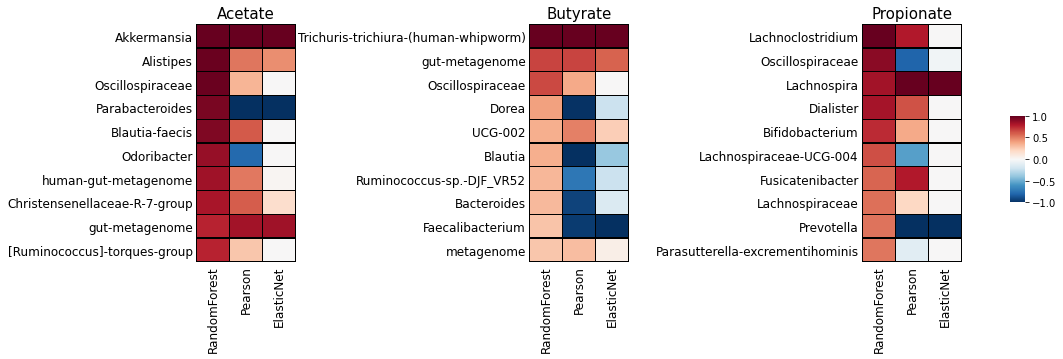

In [37]:
fig, ax = plt.subplots(figsize=(14, 6), nrows=1, ncols=3, constrained_layout=True, sharex=True)
cbar_ax = fig.add_axes([0.94, .45, .015, .2])
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    curr_df = df_joined[df_joined.SCFA==scfa].set_index('Taxon')
    curr_df = curr_df.drop('SCFA', axis=1)
    curr_df = curr_df.sort_values(by='RandomForest', ascending=False)
    curr_df = curr_df.iloc[0:10, :]
     
    # normalize to -1 and 1
    for c in ['ElasticNet','Pearson','RandomForest']:
        if c!='RandomForest':
            curr_df.loc[curr_df[c]<0,c] = curr_df.loc[curr_df[c]<0,c]/np.abs(curr_df.loc[curr_df[c]<0,c].min())
        curr_df.loc[curr_df[c]>=0,c] = curr_df.loc[curr_df[c]>=0,c]/curr_df.loc[curr_df[c]>=0,c].max()

    # plot    
    _ = sns.heatmap(curr_df.values, ax=ax[k], cmap='RdBu_r', vmin=-1, vmax=1, cbar = False if k!=2 else True, cbar_ax = None if k!=2 else cbar_ax, linewidths=0.25, linecolor='black')
    ax[k].set_xticklabels(['RandomForest','Pearson','ElasticNet'], rotation=90, fontsize=12)
    ax[k].set_title(scfa, fontsize=15)
    ax[k].set_yticklabels(curr_df.index, rotation=0, fontsize=12)
    ax[k].tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()

In [29]:
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scfa_producer_top10.pdf", format="pdf")